<h1>Data Science Final Project (Fine Tuning only)</h1>
<h3>Muhammad Daffa Rudiyanto 26002104783</h3>

<h3>Setup</h3>

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import transformers
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
from torch.utils.data import TensorDataset, Dataset, DataLoader
from transformers import BertTokenizer, BertModel


In [2]:
SEED = 4
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if cuda.is_available():
    cuda.manual_seed(SEED)
    cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
df = pd.read_csv(r"MuhammadDaffaRudiyanto_animedataset.csv")
print(len(df))
df.head()

25581


,Title,Synopsis,Status,Genres,Type,Studios,Members,Reviewer,Ratings,Score
0,A A B C,Music video for the song A A B C by Mieko Hiro...,Finished Airing,"Music, Kids",Music,NaN,73,NaN,G - All Ages,NaN
1,A Ben Mao,NaN,Finished Airing,Kids,TV,NaN,153,NaN,PG - Children,NaN
2,A Brightening Life,"Above ground, there are many people, coming an...",Finished Airing,"Drama, Music",Movie,NaN,510,234.0,PG - Children,5.50
3,A Cappella Samurai: Harmony-tai wa Edo wo Sukuu,NaN,Currently Airing,"Comedy, Historical, Music",ONA,NaN,99,NaN,PG-13 - Teens 13 or older,NaN
4,A Christmas Song,Music video for A Christmas Song by Monkey Maj...,Finished Airing,Music,Music,NaN,519,273.0,G - All Ages,5.55


<h3>Data Preprocessing</h3>

In [4]:
#Check number of missing value
missing_values = df.isna().sum()
rows_with_missing_value = df.isna().any(axis=1).sum()

print(missing_values)
print("Numbers of rows with at least one missing data:", rows_with_missing_value)

Title           0
Synopsis     4677
Status          0
Genres        128
Type            0
Studios     10693
Members         0
Reviewer     9186
Ratings       542
Score        9186
dtype: int64
Numbers of rows with at least one missing data: 13341


In [5]:
# rows_with_empty_values = df[df[['Studios', 'Score']].isna().all(axis=1)].shape[0]

# print("Number of data points with empty values in all specified columns:", rows_with_empty_values)

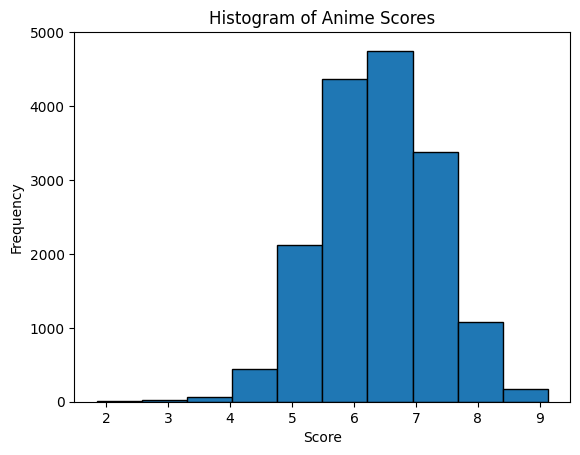

In [6]:
plt.hist(df['Score'], bins=10, edgecolor='black')
plt.title('Histogram of Anime Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.ylim(0, 5000)
plt.show()

In [7]:
# Dropping rows with NaN values in specific columns
df = df.dropna(subset=['Score', 'Synopsis', 'Genres', 'Ratings', 'Studios'])

# Filtering out specific categories and values
df = df[~df['Type'].isin(['Music', 'Special', 'Unknown']) &
        (df['Ratings'] != "Rx - Hentai") &
        ~df['Status'].isin(["Currently Airing", "Not yet aired"])]

df['Members'] = df['Members'].astype(float)


# df = df.drop(['Title', 'Status'], axis=1)
bins = [0, 6.8, float('inf')]  # Start bins from 0
labels = [0, 1]  # Labels for the bins
df['bins_score'] = pd.cut(df['Score'], bins=bins, labels=labels, right=False)
df['bins_score'] = df['bins_score'].astype(float)

df = df.reset_index(drop=True)

print(len(df))

8910


<ipython-input-7-c63c72d14dc8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Members'] = df['Members'].astype(float)
<ipython-input-7-c63c72d14dc8>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bins_score'] = pd.cut(df['Score'], bins=bins, labels=labels, right=False)
<ipython-input-7-c63c72d14dc8>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [8]:
missing_values = df.isna().sum()
print(missing_values)

Title         0
Synopsis      0
Status        0
Genres        0
Type          0
Studios       0
Members       0
Reviewer      0
Ratings       0
Score         0
bins_score    0
dtype: int64


In [9]:
df['bins_score'].value_counts()

0.0    4676
1.0    4234
Name: bins_score, dtype: int64

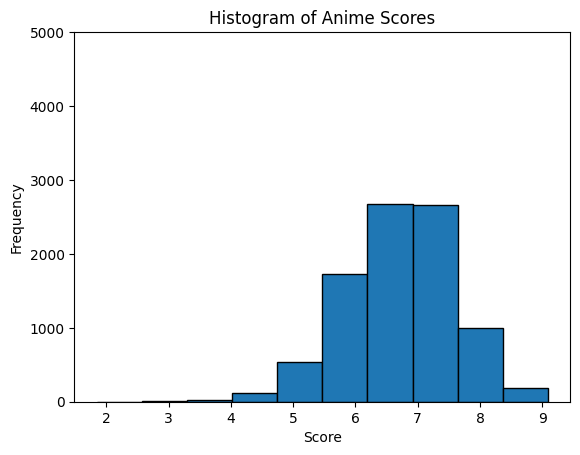

In [10]:
plt.hist(df['Score'], bins=10, edgecolor='black')
plt.title('Histogram of Anime Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.ylim(0, 5000)
plt.show()

In [11]:
df = df.sample(frac=1, random_state=SEED)
df = df.reset_index(drop=True)
df.head()

,Title,Synopsis,Status,Genres,Type,Studios,Members,Reviewer,Ratings,Score,bins_score
0,Kiznaiver,Katsuhira Agata is a quiet and reserved teenag...,Finished Airing,"Drama, Romance, Sci-Fi",TV,Trigger,730875.0,353836.0,PG-13 - Teens 13 or older,7.37,1.0
1,Haikyuu!! Tokushuu! Haru-kou Volley ni Kaketa ...,The OVA episode revisits the primary matches f...,Finished Airing,"Sports, School, Team Sports, Shounen",OVA,Production I.G,37726.0,11717.0,PG-13 - Teens 13 or older,7.52,1.0
2,Wagamama High Spec,The adorable girls of Ousui Academy's student ...,Finished Airing,"Comedy, School",TV,AXsiZ,33275.0,13785.0,PG-13 - Teens 13 or older,5.38,0.0
3,M3: Sono Kuroki Hagane,"In a dark void known as the Lightless Realm, a...",Finished Airing,"Action, Drama, Mystery, Sci-Fi, Mecha, Psychol...",TV,"Satelight, C2C",56435.0,18694.0,R - 17+ (violence & profanity),6.57,0.0
4,Casshern: Robot Hunter,"In the near future, robot technology has advan...",Finished Airing,"Adventure, Sci-Fi, Mecha",OVA,Tatsunoko Production,8766.0,3376.0,PG-13 - Teens 13 or older,6.31,0.0


<h3>Deep Learning Part 1: Fine-tuning BERT for Synopsis</h3>

In [12]:
# MAX_LEN = 200
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
EPOCHS = 6
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',  do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.Synopsis = dataframe.Synopsis
        self.targets = self.data.Score
        self.max_len = max_len

    def __len__(self):
        return len(self.Synopsis)

    def __getitem__(self, index):
        Synopsis = str(self.Synopsis[index])
        Synopsis = " ".join(Synopsis.split())

        # inputs = self.tokenizer.encode_plus(
        #     Synopsis,
        #     None,
        #     add_special_tokens=True,
        #     max_length=self.max_len,
        #     pad_to_max_length=True,
        #     return_token_type_ids=True
        # )

        inputs = self.tokenizer.encode_plus(
            Synopsis,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )

        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [14]:
new_df = df.loc[:, ['Synopsis', 'Score']]
new_df = new_df.reset_index(drop=True)

In [15]:
# Creating the dataset and dataloader for the neural network

# Define the size of the training set
train_size = 0.8

# Perform a stratified split to maintain the distribution of 'bins_score' in both sets
# train_dataset, test_dataset = train_test_split(new_df, train_size=train_size, random_state=SEED)
train_dataset, test_dataset = train_test_split(new_df, train_size=train_size, stratify=df['bins_score'], random_state=SEED)

# Reset index for both datasets
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (8910, 2)
TRAIN Dataset: (7128, 2)
TEST Dataset: (1782, 2)


In [16]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [17]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1)  # Output a single continuous value

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [18]:
def loss_fn(outputs, targets):
    return torch.nn.L1Loss()(outputs.view(-1), targets.view(-1))  # Mean Absolute Error Loss
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [19]:
def train(epoch):
    model.train()
    fin_targets_train = []
    fin_outputs_train = []
    for _, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        fin_targets_train.extend(targets.cpu().detach().numpy().tolist())
        fin_outputs_train.extend(outputs.cpu().detach().numpy().tolist())

        if _ % 5000 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')

        loss.backward()
        optimizer.step()

    return fin_outputs_train, fin_targets_train

def validation(epoch):
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(outputs.cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss:  6.368054389953613
Epoch 0 - Training Mean Absolute Error: 0.9215291855121439


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 0 - Validation Mean Absolute Error: 0.6285561153249173
Epoch: 1, Loss:  0.5999775528907776


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1 - Training Mean Absolute Error: 0.5999153819181836


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1 - Validation Mean Absolute Error: 0.5740363512242549
Epoch: 2, Loss:  0.6663150787353516


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 2 - Training Mean Absolute Error: 0.5568501100228425


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 2 - Validation Mean Absolute Error: 0.6029282416291242
Epoch: 3, Loss:  0.5193985104560852


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 3 - Training Mean Absolute Error: 0.5126231801931305


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 3 - Validation Mean Absolute Error: 0.5798782470116578
Epoch: 4, Loss:  0.2660781741142273


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 4 - Training Mean Absolute Error: 0.4533388799121217


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 4 - Validation Mean Absolute Error: 0.5899044065229285
Epoch: 5, Loss:  0.2957577109336853


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 5 - Training Mean Absolute Error: 0.40381818563247773


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 5 - Validation Mean Absolute Error: 0.5437738991746999


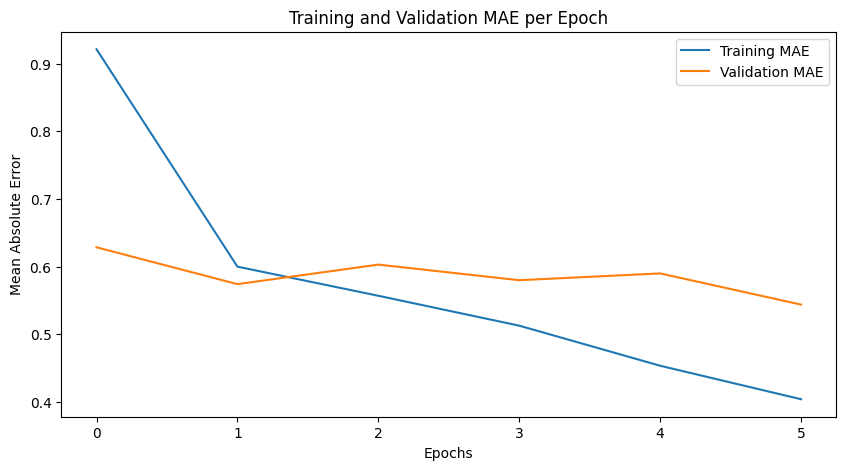

In [20]:
# Main training and validation loop

import matplotlib.pyplot as plt

# Lists to store metrics
training_mae_list = []
validation_mae_list = []

# Main training and validation loop
for epoch in range(EPOCHS):
    # Existing code for training
    outputs_train, targets_train = train(epoch)
    outputs_train = np.squeeze(outputs_train)
    mae_train = mean_absolute_error(targets_train, outputs_train)
    training_mae_list.append(mae_train)
    print(f"Epoch {epoch} - Training Mean Absolute Error: {mae_train}")

    # Existing code for validation
    outputs, targets = validation(epoch)
    outputs = np.squeeze(outputs)
    mae = mean_absolute_error(targets, outputs)
    validation_mae_list.append(mae)
    print(f"Epoch {epoch} - Validation Mean Absolute Error: {mae}")

# Plotting the metrics
plt.figure(figsize=(10, 5))
plt.plot(training_mae_list, label='Training MAE')
plt.plot(validation_mae_list, label='Validation MAE')
plt.title('Training and Validation MAE per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


In [21]:
torch.save(model.state_dict(), 'fine_tuned_bert_model_final.pth')